In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
import stable_baselines3 as sb3
from stable_baselines3.common.env_checker import check_env
from dm_control.rl.control import PhysicsError

from flygym.envs.nmf_mujoco import MuJoCoParameters
from cpg_controller import NMFCPG

/home/sibwang/anaconda3/envs/flygym/lib/python3.8/site-packages/torch/utils/tensorboard/__init__.py:4: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if not hasattr(tensorboard, "__version__") or LooseVersion(
/home/sibwang/anaconda3/envs/flygym/lib/python3.8/site-packages/torch/utils/tensorboard/__init__.py:6: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  ) < LooseVersion("1.15"):


In [3]:
np.random.seed(0)
sb3.common.utils.set_random_seed(0, using_cuda=True)

In [4]:
class RLTask(gym.Env):
    def __init__(self, decision_dt=0.05, render_mode="headless", log=False):
        self.sim_params = MuJoCoParameters(render_mode=render_mode)
        self.nmf_cpg = NMFCPG(sim_params=self.sim_params)
        self.observation_space = gym.spaces.Box(low=-np.inf, high=np.inf, shape=(6,))
        self.action_space = gym.spaces.Box(low=-1, high=1, shape=(2,))
        self.decision_dt = decision_dt
        self.target_pos = np.array([10, np.random.uniform(-5, 5)])
        self.num_substeps = int(decision_dt / MuJoCoParameters.timestep)
        self.curr_time = 0
        self.log = log
        self._last_pos = np.zeros(2)
        self._curr_action = np.zeros(2)

    def _get_obs(self, curr_pos):
        vector_to_target = self.target_pos - curr_pos
        vector_to_target /= np.linalg.norm(vector_to_target)
        vector_curr_heading = curr_pos - self._last_pos
        vector_curr_heading /= np.linalg.norm(vector_curr_heading)
        obs = np.array(
            [*vector_to_target, *vector_curr_heading, *self._curr_action],
            dtype="float32",
        )
        assert obs.shape == (6,)
        return obs

    def _get_reward(self, curr_pos):
        curr_dist = np.linalg.norm(curr_pos - self.target_pos)
        last_dist = np.linalg.norm(self._last_pos - self.target_pos)
        dist_dec = last_dist - curr_dist
        if curr_dist < 2:
            reward = 10
            terminated = True
        elif curr_pos[0] > 12:
            reward = -10
            terminated = True
        else:
            reward = dist_dec
            terminated = False
        return reward, terminated

    def reset(self):
        self.nmf_cpg.reset()
        self.target_pos = np.array([10, np.random.uniform(-8, 8)])
        self.curr_time = 0
        self._last_pos = np.zeros(2)
        self._curr_action = np.zeros(2)
        return self._get_obs(np.array([0.01, 0])), {}

    def step(self, action):
        try:
            for i in range(self.num_substeps):
                raw_obs, _, _, _, _ = self.nmf_cpg.step(action)
                self.nmf_cpg.render()
        except PhysicsError:
            print("Physics error, resetting environment")
            return np.zeros((6,), dtype="float32"), 0, False, True, {}
        curr_pos = raw_obs["fly"][0, :2]
        self.curr_time += self.decision_dt
        
        obs = self._get_obs(curr_pos)
        reward, terminated = self._get_reward(curr_pos)
        if self.curr_time >= 1 and not terminated:
            reward = -10
            truncated = True
        else:
            truncated = False
        
        self._last_pos = curr_pos
        self._curr_action = action
        
        if self.log:
            curr_dist = np.linalg.norm(curr_pos - self.target_pos)
            print(
                f"t={self.curr_time:.2f} "
                f"fly pos=({curr_pos[0]:.2f}, {curr_pos[1]:.2f}) "
                f"target pos=({self.target_pos[0]:.2f}, {self.target_pos[1]:.2f}) "
                f"distance={curr_dist:.2f} "
                f"vec2target=({obs[0]:.2f}, {obs[1]:.2f}) "
                f"heading=({obs[2]:.2f}, {obs[3]:.2f}) "
                f"reward={reward:.2f}"
            )
        return obs, reward, terminated, truncated, {}

In [5]:
task = RLTask(log=True)
for i in range(20):
    obs, rew, term, trunc, info = task.step(np.array([0, 0]))
    if term:
        print("Terminated")
        break
    if trunc:
        print("Truncated")
        break

t=0.05 fly pos=(0.61, 0.07) target pos=(10.00, -0.62) distance=9.42 vec2target=(1.00, -0.07) heading=(0.99, 0.11) reward=0.60
t=0.10 fly pos=(1.74, 0.06) target pos=(10.00, -0.62) distance=8.28 vec2target=(1.00, -0.08) heading=(1.00, -0.00) reward=1.13
t=0.15 fly pos=(2.87, 0.08) target pos=(10.00, -0.62) distance=7.16 vec2target=(1.00, -0.10) heading=(1.00, 0.02) reward=1.12
t=0.20 fly pos=(4.00, 0.11) target pos=(10.00, -0.62) distance=6.04 vec2target=(0.99, -0.12) heading=(1.00, 0.02) reward=1.12
t=0.25 fly pos=(5.14, 0.14) target pos=(10.00, -0.62) distance=4.92 vec2target=(0.99, -0.15) heading=(1.00, 0.02) reward=1.12
t=0.30 fly pos=(6.25, 0.19) target pos=(10.00, -0.62) distance=3.83 vec2target=(0.98, -0.21) heading=(1.00, 0.05) reward=1.08
t=0.35 fly pos=(7.38, 0.22) target pos=(10.00, -0.62) distance=2.75 vec2target=(0.95, -0.31) heading=(1.00, 0.03) reward=1.08
t=0.40 fly pos=(8.51, 0.25) target pos=(10.00, -0.62) distance=1.73 vec2target=(0.86, -0.50) heading=(1.00, 0.02) rew

In [6]:
task = RLTask(log=False)
check_env(task)

In [7]:
model = sb3.SAC("MlpPolicy", env=task, policy_kwargs={"net_arch": [16, 16]}, verbose=2, learning_rate=0.01)
model.learn(total_timesteps=3000, progress_bar=True)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


Output()

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 11.8     |
|    ep_rew_mean     | -4.29    |
| time/              |          |
|    episodes        | 4        |
|    fps             | 2        |
|    time_elapsed    | 21       |
|    total_timesteps | 47       |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 10.9     |
|    ep_rew_mean     | 0.842    |
| time/              |          |
|    episodes        | 8        |
|    fps             | 2        |
|    time_elapsed    | 39       |
|    total_timesteps | 87       |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 10.4     |
|    ep_rew_mean     | 2.95     |
| time/              |          |
|    episodes        | 12       |
|    fps             | 2        |
|    time_elapsed    | 57       |
|    total_timesteps | 125      |
| train/             |          |
|    actor_loss      | -2.3     |
|    critic_loss     | 11.4     |
|    ent_coef        | 0.794    |
|    ent_coef_loss   | -0.774   |
|    learning_rate   | 0.01     |
|    n_updates       | 24       |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 9.94     |
|    ep_rew_mean     | 3.7      |
| time/              |          |
|    episodes        | 16       |
|    fps             | 2        |
|    time_elapsed    | 72       |
|    total_timesteps | 159      |
| train/             |          |
|    actor_loss      | -1.71    |
|    critic_loss     | 3.64     |
|    ent_coef        | 0.567    |
|    ent_coef_loss   | -1.78    |
|    learning_rate   | 0.01     |
|    n_updates       | 58       |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 9.5      |
|    ep_rew_mean     | 5.42     |
| time/              |          |
|    episodes        | 20       |
|    fps             | 2        |
|    time_elapsed    | 86       |
|    total_timesteps | 190      |
| train/             |          |
|    actor_loss      | -1.65    |
|    critic_loss     | 3.8      |
|    ent_coef        | 0.421    |
|    ent_coef_loss   | -2.62    |
|    learning_rate   | 0.01     |
|    n_updates       | 89       |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 9.46     |
|    ep_rew_mean     | 4.74     |
| time/              |          |
|    episodes        | 24       |
|    fps             | 2        |
|    time_elapsed    | 103      |
|    total_timesteps | 227      |
| train/             |          |
|    actor_loss      | -1.35    |
|    critic_loss     | 1.84     |
|    ent_coef        | 0.297    |
|    ent_coef_loss   | -3.42    |
|    learning_rate   | 0.01     |
|    n_updates       | 126      |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 9.43     |
|    ep_rew_mean     | 4.22     |
| time/              |          |
|    episodes        | 28       |
|    fps             | 2        |
|    time_elapsed    | 120      |
|    total_timesteps | 264      |
| train/             |          |
|    actor_loss      | -0.878   |
|    critic_loss     | 2.2      |
|    ent_coef        | 0.217    |
|    ent_coef_loss   | -3.88    |
|    learning_rate   | 0.01     |
|    n_updates       | 163      |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 9.34     |
|    ep_rew_mean     | 3.88     |
| time/              |          |
|    episodes        | 32       |
|    fps             | 2        |
|    time_elapsed    | 136      |
|    total_timesteps | 299      |
| train/             |          |
|    actor_loss      | -1.23    |
|    critic_loss     | 1.89     |
|    ent_coef        | 0.165    |
|    ent_coef_loss   | -3.4     |
|    learning_rate   | 0.01     |
|    n_updates       | 198      |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 9.14     |
|    ep_rew_mean     | 4.84     |
| time/              |          |
|    episodes        | 36       |
|    fps             | 2        |
|    time_elapsed    | 149      |
|    total_timesteps | 329      |
| train/             |          |
|    actor_loss      | -1.19    |
|    critic_loss     | 1.72     |
|    ent_coef        | 0.133    |
|    ent_coef_loss   | -3.22    |
|    learning_rate   | 0.01     |
|    n_updates       | 228      |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 8.97     |
|    ep_rew_mean     | 6.14     |
| time/              |          |
|    episodes        | 40       |
|    fps             | 2        |
|    time_elapsed    | 163      |
|    total_timesteps | 359      |
| train/             |          |
|    actor_loss      | -1.68    |
|    critic_loss     | 2.88     |
|    ent_coef        | 0.111    |
|    ent_coef_loss   | -3.49    |
|    learning_rate   | 0.01     |
|    n_updates       | 258      |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 8.98     |
|    ep_rew_mean     | 5.36     |
| time/              |          |
|    episodes        | 44       |
|    fps             | 2        |
|    time_elapsed    | 179      |
|    total_timesteps | 395      |
| train/             |          |
|    actor_loss      | -1.36    |
|    critic_loss     | 1.89     |
|    ent_coef        | 0.09     |
|    ent_coef_loss   | -4.46    |
|    learning_rate   | 0.01     |
|    n_updates       | 294      |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 9        |
|    ep_rew_mean     | 5.12     |
| time/              |          |
|    episodes        | 48       |
|    fps             | 2        |
|    time_elapsed    | 196      |
|    total_timesteps | 432      |
| train/             |          |
|    actor_loss      | -0.897   |
|    critic_loss     | 2.75     |
|    ent_coef        | 0.0725   |
|    ent_coef_loss   | -3.37    |
|    learning_rate   | 0.01     |
|    n_updates       | 331      |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 8.94     |
|    ep_rew_mean     | 5.2      |
| time/              |          |
|    episodes        | 52       |
|    fps             | 2        |
|    time_elapsed    | 211      |
|    total_timesteps | 465      |
| train/             |          |
|    actor_loss      | -1.18    |
|    critic_loss     | 1.96     |
|    ent_coef        | 0.0613   |
|    ent_coef_loss   | -3.28    |
|    learning_rate   | 0.01     |
|    n_updates       | 364      |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 8.95     |
|    ep_rew_mean     | 5.75     |
| time/              |          |
|    episodes        | 56       |
|    fps             | 2        |
|    time_elapsed    | 227      |
|    total_timesteps | 501      |
| train/             |          |
|    actor_loss      | -1.43    |
|    critic_loss     | 2.83     |
|    ent_coef        | 0.0534   |
|    ent_coef_loss   | -1.52    |
|    learning_rate   | 0.01     |
|    n_updates       | 400      |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 9.18     |
|    ep_rew_mean     | 5.49     |
| time/              |          |
|    episodes        | 60       |
|    fps             | 2        |
|    time_elapsed    | 252      |
|    total_timesteps | 551      |
| train/             |          |
|    actor_loss      | -1.04    |
|    critic_loss     | 1.65     |
|    ent_coef        | 0.0463   |
|    ent_coef_loss   | -1.65    |
|    learning_rate   | 0.01     |
|    n_updates       | 450      |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 9.17     |
|    ep_rew_mean     | 5.94     |
| time/              |          |
|    episodes        | 64       |
|    fps             | 2        |
|    time_elapsed    | 269      |
|    total_timesteps | 587      |
| train/             |          |
|    actor_loss      | -1.68    |
|    critic_loss     | 1.76     |
|    ent_coef        | 0.043    |
|    ent_coef_loss   | -0.977   |
|    learning_rate   | 0.01     |
|    n_updates       | 486      |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 9.32     |
|    ep_rew_mean     | 5.75     |
| time/              |          |
|    episodes        | 68       |
|    fps             | 2        |
|    time_elapsed    | 291      |
|    total_timesteps | 634      |
| train/             |          |
|    actor_loss      | -2       |
|    critic_loss     | 2        |
|    ent_coef        | 0.0412   |
|    ent_coef_loss   | 1.02     |
|    learning_rate   | 0.01     |
|    n_updates       | 533      |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 9.26     |
|    ep_rew_mean     | 6.15     |
| time/              |          |
|    episodes        | 72       |
|    fps             | 2        |
|    time_elapsed    | 306      |
|    total_timesteps | 667      |
| train/             |          |
|    actor_loss      | -1.91    |
|    critic_loss     | 2.31     |
|    ent_coef        | 0.0421   |
|    ent_coef_loss   | 1.37     |
|    learning_rate   | 0.01     |
|    n_updates       | 566      |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 9.13     |
|    ep_rew_mean     | 6.77     |
| time/              |          |
|    episodes        | 76       |
|    fps             | 2        |
|    time_elapsed    | 318      |
|    total_timesteps | 694      |
| train/             |          |
|    actor_loss      | -1.68    |
|    critic_loss     | 2.56     |
|    ent_coef        | 0.0428   |
|    ent_coef_loss   | 0.445    |
|    learning_rate   | 0.01     |
|    n_updates       | 593      |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 9.26     |
|    ep_rew_mean     | 7.03     |
| time/              |          |
|    episodes        | 80       |
|    fps             | 2        |
|    time_elapsed    | 338      |
|    total_timesteps | 741      |
| train/             |          |
|    actor_loss      | -1.69    |
|    critic_loss     | 4.26     |
|    ent_coef        | 0.0456   |
|    ent_coef_loss   | -0.6     |
|    learning_rate   | 0.01     |
|    n_updates       | 640      |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 9.32     |
|    ep_rew_mean     | 7.25     |
| time/              |          |
|    episodes        | 84       |
|    fps             | 2        |
|    time_elapsed    | 357      |
|    total_timesteps | 783      |
| train/             |          |
|    actor_loss      | -2.35    |
|    critic_loss     | 3.3      |
|    ent_coef        | 0.0508   |
|    ent_coef_loss   | 2.53     |
|    learning_rate   | 0.01     |
|    n_updates       | 682      |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 9.19     |
|    ep_rew_mean     | 7.73     |
| time/              |          |
|    episodes        | 88       |
|    fps             | 2        |
|    time_elapsed    | 368      |
|    total_timesteps | 809      |
| train/             |          |
|    actor_loss      | -2.16    |
|    critic_loss     | 3.18     |
|    ent_coef        | 0.0535   |
|    ent_coef_loss   | 2.53     |
|    learning_rate   | 0.01     |
|    n_updates       | 708      |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 9.34     |
|    ep_rew_mean     | 7.66     |
| time/              |          |
|    episodes        | 92       |
|    fps             | 2        |
|    time_elapsed    | 391      |
|    total_timesteps | 859      |
| train/             |          |
|    actor_loss      | -2.39    |
|    critic_loss     | 3.2      |
|    ent_coef        | 0.0636   |
|    ent_coef_loss   | 0.481    |
|    learning_rate   | 0.01     |
|    n_updates       | 758      |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 9.25     |
|    ep_rew_mean     | 8.1      |
| time/              |          |
|    episodes        | 96       |
|    fps             | 2        |
|    time_elapsed    | 404      |
|    total_timesteps | 888      |
| train/             |          |
|    actor_loss      | -2.83    |
|    critic_loss     | 3.01     |
|    ent_coef        | 0.0668   |
|    ent_coef_loss   | 0.563    |
|    learning_rate   | 0.01     |
|    n_updates       | 787      |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 9.17     |
|    ep_rew_mean     | 8.28     |
| time/              |          |
|    episodes        | 100      |
|    fps             | 2        |
|    time_elapsed    | 417      |
|    total_timesteps | 917      |
| train/             |          |
|    actor_loss      | -2.93    |
|    critic_loss     | 3.1      |
|    ent_coef        | 0.0708   |
|    ent_coef_loss   | 0.262    |
|    learning_rate   | 0.01     |
|    n_updates       | 816      |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 9.32     |
|    ep_rew_mean     | 8.46     |
| time/              |          |
|    episodes        | 104      |
|    fps             | 2        |
|    time_elapsed    | 445      |
|    total_timesteps | 979      |
| train/             |          |
|    actor_loss      | -3.28    |
|    critic_loss     | 4.12     |
|    ent_coef        | 0.0732   |
|    ent_coef_loss   | -1.04    |
|    learning_rate   | 0.01     |
|    n_updates       | 878      |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 9.36     |
|    ep_rew_mean     | 8.47     |
| time/              |          |
|    episodes        | 108      |
|    fps             | 2        |
|    time_elapsed    | 464      |
|    total_timesteps | 1023     |
| train/             |          |
|    actor_loss      | -3.12    |
|    critic_loss     | 4.74     |
|    ent_coef        | 0.0722   |
|    ent_coef_loss   | -0.496   |
|    learning_rate   | 0.01     |
|    n_updates       | 922      |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 9.23     |
|    ep_rew_mean     | 8.69     |
| time/              |          |
|    episodes        | 112      |
|    fps             | 2        |
|    time_elapsed    | 475      |
|    total_timesteps | 1048     |
| train/             |          |
|    actor_loss      | -3.19    |
|    critic_loss     | 3.9      |
|    ent_coef        | 0.0717   |
|    ent_coef_loss   | -0.873   |
|    learning_rate   | 0.01     |
|    n_updates       | 947      |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 9.19     |
|    ep_rew_mean     | 8.77     |
| time/              |          |
|    episodes        | 116      |
|    fps             | 2        |
|    time_elapsed    | 488      |
|    total_timesteps | 1078     |
| train/             |          |
|    actor_loss      | -2.99    |
|    critic_loss     | 3.52     |
|    ent_coef        | 0.0727   |
|    ent_coef_loss   | 0.91     |
|    learning_rate   | 0.01     |
|    n_updates       | 977      |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 9.18     |
|    ep_rew_mean     | 8.81     |
| time/              |          |
|    episodes        | 120      |
|    fps             | 2        |
|    time_elapsed    | 502      |
|    total_timesteps | 1108     |
| train/             |          |
|    actor_loss      | -3.41    |
|    critic_loss     | 3.68     |
|    ent_coef        | 0.0728   |
|    ent_coef_loss   | -0.515   |
|    learning_rate   | 0.01     |
|    n_updates       | 1007     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 9.15     |
|    ep_rew_mean     | 9.52     |
| time/              |          |
|    episodes        | 124      |
|    fps             | 2        |
|    time_elapsed    | 517      |
|    total_timesteps | 1142     |
| train/             |          |
|    actor_loss      | -3.97    |
|    critic_loss     | 2.77     |
|    ent_coef        | 0.072    |
|    ent_coef_loss   | -0.795   |
|    learning_rate   | 0.01     |
|    n_updates       | 1041     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 9.19     |
|    ep_rew_mean     | 9.98     |
| time/              |          |
|    episodes        | 128      |
|    fps             | 2        |
|    time_elapsed    | 535      |
|    total_timesteps | 1183     |
| train/             |          |
|    actor_loss      | -3.68    |
|    critic_loss     | 3.24     |
|    ent_coef        | 0.0729   |
|    ent_coef_loss   | 0.207    |
|    learning_rate   | 0.01     |
|    n_updates       | 1082     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 9.2      |
|    ep_rew_mean     | 10.5     |
| time/              |          |
|    episodes        | 132      |
|    fps             | 2        |
|    time_elapsed    | 551      |
|    total_timesteps | 1219     |
| train/             |          |
|    actor_loss      | -4.25    |
|    critic_loss     | 4.96     |
|    ent_coef        | 0.0734   |
|    ent_coef_loss   | -0.162   |
|    learning_rate   | 0.01     |
|    n_updates       | 1118     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 9.25     |
|    ep_rew_mean     | 10.7     |
| time/              |          |
|    episodes        | 136      |
|    fps             | 2        |
|    time_elapsed    | 567      |
|    total_timesteps | 1254     |
| train/             |          |
|    actor_loss      | -4.31    |
|    critic_loss     | 2.76     |
|    ent_coef        | 0.0731   |
|    ent_coef_loss   | 0.941    |
|    learning_rate   | 0.01     |
|    n_updates       | 1153     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 9.21     |
|    ep_rew_mean     | 10.5     |
| time/              |          |
|    episodes        | 140      |
|    fps             | 2        |
|    time_elapsed    | 579      |
|    total_timesteps | 1280     |
| train/             |          |
|    actor_loss      | -4.65    |
|    critic_loss     | 2.76     |
|    ent_coef        | 0.0744   |
|    ent_coef_loss   | -1.12    |
|    learning_rate   | 0.01     |
|    n_updates       | 1179     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 9.32     |
|    ep_rew_mean     | 10.8     |
| time/              |          |
|    episodes        | 144      |
|    fps             | 2        |
|    time_elapsed    | 599      |
|    total_timesteps | 1327     |
| train/             |          |
|    actor_loss      | -4.79    |
|    critic_loss     | 2.91     |
|    ent_coef        | 0.0739   |
|    ent_coef_loss   | -0.582   |
|    learning_rate   | 0.01     |
|    n_updates       | 1226     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 9.41     |
|    ep_rew_mean     | 11       |
| time/              |          |
|    episodes        | 148      |
|    fps             | 2        |
|    time_elapsed    | 619      |
|    total_timesteps | 1373     |
| train/             |          |
|    actor_loss      | -4.37    |
|    critic_loss     | 6.22     |
|    ent_coef        | 0.0748   |
|    ent_coef_loss   | 0.07     |
|    learning_rate   | 0.01     |
|    n_updates       | 1272     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 9.39     |
|    ep_rew_mean     | 11.3     |
| time/              |          |
|    episodes        | 152      |
|    fps             | 2        |
|    time_elapsed    | 633      |
|    total_timesteps | 1404     |
| train/             |          |
|    actor_loss      | -4.2     |
|    critic_loss     | 5.14     |
|    ent_coef        | 0.077    |
|    ent_coef_loss   | -0.0722  |
|    learning_rate   | 0.01     |
|    n_updates       | 1303     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 9.28     |
|    ep_rew_mean     | 11.5     |
| time/              |          |
|    episodes        | 156      |
|    fps             | 2        |
|    time_elapsed    | 645      |
|    total_timesteps | 1429     |
| train/             |          |
|    actor_loss      | -4.7     |
|    critic_loss     | 4.76     |
|    ent_coef        | 0.0766   |
|    ent_coef_loss   | -0.533   |
|    learning_rate   | 0.01     |
|    n_updates       | 1328     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 9.08     |
|    ep_rew_mean     | 12.2     |
| time/              |          |
|    episodes        | 160      |
|    fps             | 2        |
|    time_elapsed    | 659      |
|    total_timesteps | 1459     |
| train/             |          |
|    actor_loss      | -4.04    |
|    critic_loss     | 4.45     |
|    ent_coef        | 0.0757   |
|    ent_coef_loss   | 0.239    |
|    learning_rate   | 0.01     |
|    n_updates       | 1358     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 9.14     |
|    ep_rew_mean     | 12.1     |
| time/              |          |
|    episodes        | 164      |
|    fps             | 2        |
|    time_elapsed    | 678      |
|    total_timesteps | 1501     |
| train/             |          |
|    actor_loss      | -4.69    |
|    critic_loss     | 4.99     |
|    ent_coef        | 0.0763   |
|    ent_coef_loss   | -0.506   |
|    learning_rate   | 0.01     |
|    n_updates       | 1400     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 8.94     |
|    ep_rew_mean     | 12.7     |
| time/              |          |
|    episodes        | 168      |
|    fps             | 2        |
|    time_elapsed    | 691      |
|    total_timesteps | 1528     |
| train/             |          |
|    actor_loss      | -4.9     |
|    critic_loss     | 3.63     |
|    ent_coef        | 0.0735   |
|    ent_coef_loss   | -0.359   |
|    learning_rate   | 0.01     |
|    n_updates       | 1427     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 8.88     |
|    ep_rew_mean     | 12.9     |
| time/              |          |
|    episodes        | 172      |
|    fps             | 2        |
|    time_elapsed    | 703      |
|    total_timesteps | 1555     |
| train/             |          |
|    actor_loss      | -3.97    |
|    critic_loss     | 6.32     |
|    ent_coef        | 0.07     |
|    ent_coef_loss   | -0.0716  |
|    learning_rate   | 0.01     |
|    n_updates       | 1454     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 8.87     |
|    ep_rew_mean     | 12.9     |
| time/              |          |
|    episodes        | 176      |
|    fps             | 2        |
|    time_elapsed    | 715      |
|    total_timesteps | 1581     |
| train/             |          |
|    actor_loss      | -4.84    |
|    critic_loss     | 5.14     |
|    ent_coef        | 0.0676   |
|    ent_coef_loss   | 0.949    |
|    learning_rate   | 0.01     |
|    n_updates       | 1480     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 8.73     |
|    ep_rew_mean     | 13       |
| time/              |          |
|    episodes        | 180      |
|    fps             | 2        |
|    time_elapsed    | 730      |
|    total_timesteps | 1614     |
| train/             |          |
|    actor_loss      | -4.41    |
|    critic_loss     | 4.98     |
|    ent_coef        | 0.0675   |
|    ent_coef_loss   | 0.142    |
|    learning_rate   | 0.01     |
|    n_updates       | 1513     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 8.61     |
|    ep_rew_mean     | 13.3     |
| time/              |          |
|    episodes        | 184      |
|    fps             | 2        |
|    time_elapsed    | 744      |
|    total_timesteps | 1644     |
| train/             |          |
|    actor_loss      | -4.2     |
|    critic_loss     | 4.59     |
|    ent_coef        | 0.0675   |
|    ent_coef_loss   | 0.343    |
|    learning_rate   | 0.01     |
|    n_updates       | 1543     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 8.62     |
|    ep_rew_mean     | 13       |
| time/              |          |
|    episodes        | 188      |
|    fps             | 2        |
|    time_elapsed    | 757      |
|    total_timesteps | 1671     |
| train/             |          |
|    actor_loss      | -4.96    |
|    critic_loss     | 7        |
|    ent_coef        | 0.0666   |
|    ent_coef_loss   | -0.659   |
|    learning_rate   | 0.01     |
|    n_updates       | 1570     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 8.45     |
|    ep_rew_mean     | 13.3     |
| time/              |          |
|    episodes        | 192      |
|    fps             | 2        |
|    time_elapsed    | 772      |
|    total_timesteps | 1704     |
| train/             |          |
|    actor_loss      | -5.39    |
|    critic_loss     | 3.32     |
|    ent_coef        | 0.065    |
|    ent_coef_loss   | 1.3      |
|    learning_rate   | 0.01     |
|    n_updates       | 1603     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 8.67     |
|    ep_rew_mean     | 12.8     |
| time/              |          |
|    episodes        | 196      |
|    fps             | 2        |
|    time_elapsed    | 793      |
|    total_timesteps | 1755     |
| train/             |          |
|    actor_loss      | -5.03    |
|    critic_loss     | 7.01     |
|    ent_coef        | 0.0664   |
|    ent_coef_loss   | -0.0373  |
|    learning_rate   | 0.01     |
|    n_updates       | 1654     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 8.61     |
|    ep_rew_mean     | 13       |
| time/              |          |
|    episodes        | 200      |
|    fps             | 2        |
|    time_elapsed    | 803      |
|    total_timesteps | 1778     |
| train/             |          |
|    actor_loss      | -5.92    |
|    critic_loss     | 5.1      |
|    ent_coef        | 0.0645   |
|    ent_coef_loss   | 0.17     |
|    learning_rate   | 0.01     |
|    n_updates       | 1677     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 8.34     |
|    ep_rew_mean     | 13.5     |
| time/              |          |
|    episodes        | 204      |
|    fps             | 2        |
|    time_elapsed    | 819      |
|    total_timesteps | 1813     |
| train/             |          |
|    actor_loss      | -6.08    |
|    critic_loss     | 2.78     |
|    ent_coef        | 0.0623   |
|    ent_coef_loss   | -0.552   |
|    learning_rate   | 0.01     |
|    n_updates       | 1712     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 8.2      |
|    ep_rew_mean     | 14.1     |
| time/              |          |
|    episodes        | 208      |
|    fps             | 2        |
|    time_elapsed    | 832      |
|    total_timesteps | 1843     |
| train/             |          |
|    actor_loss      | -5.75    |
|    critic_loss     | 4.93     |
|    ent_coef        | 0.0632   |
|    ent_coef_loss   | -0.416   |
|    learning_rate   | 0.01     |
|    n_updates       | 1742     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 8.29     |
|    ep_rew_mean     | 13.9     |
| time/              |          |
|    episodes        | 212      |
|    fps             | 2        |
|    time_elapsed    | 847      |
|    total_timesteps | 1877     |
| train/             |          |
|    actor_loss      | -5.83    |
|    critic_loss     | 5.56     |
|    ent_coef        | 0.0633   |
|    ent_coef_loss   | 0.391    |
|    learning_rate   | 0.01     |
|    n_updates       | 1776     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 8.26     |
|    ep_rew_mean     | 14.3     |
| time/              |          |
|    episodes        | 216      |
|    fps             | 2        |
|    time_elapsed    | 859      |
|    total_timesteps | 1904     |
| train/             |          |
|    actor_loss      | -5.27    |
|    critic_loss     | 5.1      |
|    ent_coef        | 0.0643   |
|    ent_coef_loss   | -0.47    |
|    learning_rate   | 0.01     |
|    n_updates       | 1803     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 8.26     |
|    ep_rew_mean     | 14.5     |
| time/              |          |
|    episodes        | 220      |
|    fps             | 2        |
|    time_elapsed    | 873      |
|    total_timesteps | 1934     |
| train/             |          |
|    actor_loss      | -5.27    |
|    critic_loss     | 5.88     |
|    ent_coef        | 0.0651   |
|    ent_coef_loss   | -0.469   |
|    learning_rate   | 0.01     |
|    n_updates       | 1833     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 8.25     |
|    ep_rew_mean     | 14.3     |
| time/              |          |
|    episodes        | 224      |
|    fps             | 2        |
|    time_elapsed    | 888      |
|    total_timesteps | 1967     |
| train/             |          |
|    actor_loss      | -5.68    |
|    critic_loss     | 4.75     |
|    ent_coef        | 0.0671   |
|    ent_coef_loss   | -0.293   |
|    learning_rate   | 0.01     |
|    n_updates       | 1866     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 8.3      |
|    ep_rew_mean     | 14.1     |
| time/              |          |
|    episodes        | 228      |
|    fps             | 2        |
|    time_elapsed    | 908      |
|    total_timesteps | 2013     |
| train/             |          |
|    actor_loss      | -5.62    |
|    critic_loss     | 6.45     |
|    ent_coef        | 0.0686   |
|    ent_coef_loss   | -0.344   |
|    learning_rate   | 0.01     |
|    n_updates       | 1912     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 8.27     |
|    ep_rew_mean     | 14.3     |
| time/              |          |
|    episodes        | 232      |
|    fps             | 2        |
|    time_elapsed    | 922      |
|    total_timesteps | 2046     |
| train/             |          |
|    actor_loss      | -6.06    |
|    critic_loss     | 4.7      |
|    ent_coef        | 0.0644   |
|    ent_coef_loss   | -0.959   |
|    learning_rate   | 0.01     |
|    n_updates       | 1945     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 8.13     |
|    ep_rew_mean     | 14.2     |
| time/              |          |
|    episodes        | 236      |
|    fps             | 2        |
|    time_elapsed    | 931      |
|    total_timesteps | 2067     |
| train/             |          |
|    actor_loss      | -5.86    |
|    critic_loss     | 4.78     |
|    ent_coef        | 0.0628   |
|    ent_coef_loss   | 0.661    |
|    learning_rate   | 0.01     |
|    n_updates       | 1966     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 8.31     |
|    ep_rew_mean     | 14.2     |
| time/              |          |
|    episodes        | 240      |
|    fps             | 2        |
|    time_elapsed    | 951      |
|    total_timesteps | 2111     |
| train/             |          |
|    actor_loss      | -6.03    |
|    critic_loss     | 5.47     |
|    ent_coef        | 0.0604   |
|    ent_coef_loss   | -0.219   |
|    learning_rate   | 0.01     |
|    n_updates       | 2010     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 8.11     |
|    ep_rew_mean     | 14.7     |
| time/              |          |
|    episodes        | 244      |
|    fps             | 2        |
|    time_elapsed    | 963      |
|    total_timesteps | 2138     |
| train/             |          |
|    actor_loss      | -6.64    |
|    critic_loss     | 5.6      |
|    ent_coef        | 0.0604   |
|    ent_coef_loss   | -0.306   |
|    learning_rate   | 0.01     |
|    n_updates       | 2037     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 8.15     |
|    ep_rew_mean     | 14.7     |
| time/              |          |
|    episodes        | 248      |
|    fps             | 2        |
|    time_elapsed    | 987      |
|    total_timesteps | 2188     |
| train/             |          |
|    actor_loss      | -6.76    |
|    critic_loss     | 5.96     |
|    ent_coef        | 0.0638   |
|    ent_coef_loss   | -0.0272  |
|    learning_rate   | 0.01     |
|    n_updates       | 2087     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 8.1      |
|    ep_rew_mean     | 14.9     |
| time/              |          |
|    episodes        | 252      |
|    fps             | 2        |
|    time_elapsed    | 999      |
|    total_timesteps | 2214     |
| train/             |          |
|    actor_loss      | -6.63    |
|    critic_loss     | 7.57     |
|    ent_coef        | 0.0685   |
|    ent_coef_loss   | -0.328   |
|    learning_rate   | 0.01     |
|    n_updates       | 2113     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 8.24     |
|    ep_rew_mean     | 14.7     |
| time/              |          |
|    episodes        | 256      |
|    fps             | 2        |
|    time_elapsed    | 1018     |
|    total_timesteps | 2253     |
| train/             |          |
|    actor_loss      | -5.42    |
|    critic_loss     | 5.47     |
|    ent_coef        | 0.0722   |
|    ent_coef_loss   | 0.699    |
|    learning_rate   | 0.01     |
|    n_updates       | 2152     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 8.29     |
|    ep_rew_mean     | 14.7     |
| time/              |          |
|    episodes        | 260      |
|    fps             | 2        |
|    time_elapsed    | 1033     |
|    total_timesteps | 2288     |
| train/             |          |
|    actor_loss      | -6.71    |
|    critic_loss     | 6.13     |
|    ent_coef        | 0.0713   |
|    ent_coef_loss   | -0.157   |
|    learning_rate   | 0.01     |
|    n_updates       | 2187     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 8.15     |
|    ep_rew_mean     | 15       |
| time/              |          |
|    episodes        | 264      |
|    fps             | 2        |
|    time_elapsed    | 1046     |
|    total_timesteps | 2316     |
| train/             |          |
|    actor_loss      | -6.29    |
|    critic_loss     | 6.41     |
|    ent_coef        | 0.0692   |
|    ent_coef_loss   | 0.417    |
|    learning_rate   | 0.01     |
|    n_updates       | 2215     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 8.26     |
|    ep_rew_mean     | 14.9     |
| time/              |          |
|    episodes        | 268      |
|    fps             | 2        |
|    time_elapsed    | 1063     |
|    total_timesteps | 2354     |
| train/             |          |
|    actor_loss      | -6.24    |
|    critic_loss     | 5.5      |
|    ent_coef        | 0.07     |
|    ent_coef_loss   | -0.565   |
|    learning_rate   | 0.01     |
|    n_updates       | 2253     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 8.25     |
|    ep_rew_mean     | 14.8     |
| time/              |          |
|    episodes        | 272      |
|    fps             | 2        |
|    time_elapsed    | 1075     |
|    total_timesteps | 2380     |
| train/             |          |
|    actor_loss      | -7.41    |
|    critic_loss     | 3.96     |
|    ent_coef        | 0.068    |
|    ent_coef_loss   | -1.16    |
|    learning_rate   | 0.01     |
|    n_updates       | 2279     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 8.28     |
|    ep_rew_mean     | 14.8     |
| time/              |          |
|    episodes        | 276      |
|    fps             | 2        |
|    time_elapsed    | 1088     |
|    total_timesteps | 2409     |
| train/             |          |
|    actor_loss      | -6.43    |
|    critic_loss     | 5.92     |
|    ent_coef        | 0.065    |
|    ent_coef_loss   | 0.661    |
|    learning_rate   | 0.01     |
|    n_updates       | 2308     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 8.23     |
|    ep_rew_mean     | 15       |
| time/              |          |
|    episodes        | 280      |
|    fps             | 2        |
|    time_elapsed    | 1100     |
|    total_timesteps | 2437     |
| train/             |          |
|    actor_loss      | -6.6     |
|    critic_loss     | 4.66     |
|    ent_coef        | 0.0695   |
|    ent_coef_loss   | -0.463   |
|    learning_rate   | 0.01     |
|    n_updates       | 2336     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 8.19     |
|    ep_rew_mean     | 15       |
| time/              |          |
|    episodes        | 284      |
|    fps             | 2        |
|    time_elapsed    | 1112     |
|    total_timesteps | 2463     |
| train/             |          |
|    actor_loss      | -7.23    |
|    critic_loss     | 5.69     |
|    ent_coef        | 0.0725   |
|    ent_coef_loss   | -0.439   |
|    learning_rate   | 0.01     |
|    n_updates       | 2362     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 8.17     |
|    ep_rew_mean     | 15.2     |
| time/              |          |
|    episodes        | 288      |
|    fps             | 2        |
|    time_elapsed    | 1123     |
|    total_timesteps | 2488     |
| train/             |          |
|    actor_loss      | -6.61    |
|    critic_loss     | 7.6      |
|    ent_coef        | 0.0713   |
|    ent_coef_loss   | 1.17     |
|    learning_rate   | 0.01     |
|    n_updates       | 2387     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 8.17     |
|    ep_rew_mean     | 15.2     |
| time/              |          |
|    episodes        | 292      |
|    fps             | 2        |
|    time_elapsed    | 1138     |
|    total_timesteps | 2521     |
| train/             |          |
|    actor_loss      | -7.45    |
|    critic_loss     | 6.2      |
|    ent_coef        | 0.0722   |
|    ent_coef_loss   | 0.258    |
|    learning_rate   | 0.01     |
|    n_updates       | 2420     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 7.92     |
|    ep_rew_mean     | 15.7     |
| time/              |          |
|    episodes        | 296      |
|    fps             | 2        |
|    time_elapsed    | 1150     |
|    total_timesteps | 2547     |
| train/             |          |
|    actor_loss      | -7.06    |
|    critic_loss     | 4.66     |
|    ent_coef        | 0.0759   |
|    ent_coef_loss   | -0.265   |
|    learning_rate   | 0.01     |
|    n_updates       | 2446     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 7.98     |
|    ep_rew_mean     | 15.7     |
| time/              |          |
|    episodes        | 300      |
|    fps             | 2        |
|    time_elapsed    | 1163     |
|    total_timesteps | 2576     |
| train/             |          |
|    actor_loss      | -6.57    |
|    critic_loss     | 4.9      |
|    ent_coef        | 0.0724   |
|    ent_coef_loss   | -0.697   |
|    learning_rate   | 0.01     |
|    n_updates       | 2475     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 8.02     |
|    ep_rew_mean     | 15.7     |
| time/              |          |
|    episodes        | 304      |
|    fps             | 2        |
|    time_elapsed    | 1183     |
|    total_timesteps | 2615     |
| train/             |          |
|    actor_loss      | -6.61    |
|    critic_loss     | 7.66     |
|    ent_coef        | 0.0717   |
|    ent_coef_loss   | -0.756   |
|    learning_rate   | 0.01     |
|    n_updates       | 2514     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 8        |
|    ep_rew_mean     | 15.6     |
| time/              |          |
|    episodes        | 308      |
|    fps             | 2        |
|    time_elapsed    | 1195     |
|    total_timesteps | 2643     |
| train/             |          |
|    actor_loss      | -6.67    |
|    critic_loss     | 4.78     |
|    ent_coef        | 0.0677   |
|    ent_coef_loss   | 0.547    |
|    learning_rate   | 0.01     |
|    n_updates       | 2542     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 8.06     |
|    ep_rew_mean     | 15.7     |
| time/              |          |
|    episodes        | 312      |
|    fps             | 2        |
|    time_elapsed    | 1214     |
|    total_timesteps | 2683     |
| train/             |          |
|    actor_loss      | -6.37    |
|    critic_loss     | 7.46     |
|    ent_coef        | 0.0731   |
|    ent_coef_loss   | 0.812    |
|    learning_rate   | 0.01     |
|    n_updates       | 2582     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 8.06     |
|    ep_rew_mean     | 15.7     |
| time/              |          |
|    episodes        | 316      |
|    fps             | 2        |
|    time_elapsed    | 1226     |
|    total_timesteps | 2710     |
| train/             |          |
|    actor_loss      | -6.37    |
|    critic_loss     | 8.51     |
|    ent_coef        | 0.0766   |
|    ent_coef_loss   | 0.479    |
|    learning_rate   | 0.01     |
|    n_updates       | 2609     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 8.04     |
|    ep_rew_mean     | 15.7     |
| time/              |          |
|    episodes        | 320      |
|    fps             | 2        |
|    time_elapsed    | 1239     |
|    total_timesteps | 2738     |
| train/             |          |
|    actor_loss      | -7.19    |
|    critic_loss     | 5.1      |
|    ent_coef        | 0.0755   |
|    ent_coef_loss   | -0.176   |
|    learning_rate   | 0.01     |
|    n_updates       | 2637     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 8.14     |
|    ep_rew_mean     | 15.7     |
| time/              |          |
|    episodes        | 324      |
|    fps             | 2        |
|    time_elapsed    | 1258     |
|    total_timesteps | 2781     |
| train/             |          |
|    actor_loss      | -6.66    |
|    critic_loss     | 5.39     |
|    ent_coef        | 0.0707   |
|    ent_coef_loss   | 0.445    |
|    learning_rate   | 0.01     |
|    n_updates       | 2680     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 8.07     |
|    ep_rew_mean     | 15.9     |
| time/              |          |
|    episodes        | 328      |
|    fps             | 2        |
|    time_elapsed    | 1278     |
|    total_timesteps | 2820     |
| train/             |          |
|    actor_loss      | -7.35    |
|    critic_loss     | 5.65     |
|    ent_coef        | 0.072    |
|    ent_coef_loss   | 0.185    |
|    learning_rate   | 0.01     |
|    n_updates       | 2719     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 8.02     |
|    ep_rew_mean     | 15.9     |
| time/              |          |
|    episodes        | 332      |
|    fps             | 2        |
|    time_elapsed    | 1291     |
|    total_timesteps | 2848     |
| train/             |          |
|    actor_loss      | -6.41    |
|    critic_loss     | 7.34     |
|    ent_coef        | 0.0701   |
|    ent_coef_loss   | 1.1      |
|    learning_rate   | 0.01     |
|    n_updates       | 2747     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 8.27     |
|    ep_rew_mean     | 15.5     |
| time/              |          |
|    episodes        | 336      |
|    fps             | 2        |
|    time_elapsed    | 1311     |
|    total_timesteps | 2894     |
| train/             |          |
|    actor_loss      | -7.35    |
|    critic_loss     | 6.61     |
|    ent_coef        | 0.0689   |
|    ent_coef_loss   | -0.809   |
|    learning_rate   | 0.01     |
|    n_updates       | 2793     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 8.18     |
|    ep_rew_mean     | 15.5     |
| time/              |          |
|    episodes        | 340      |
|    fps             | 2        |
|    time_elapsed    | 1327     |
|    total_timesteps | 2929     |
| train/             |          |
|    actor_loss      | -7.07    |
|    critic_loss     | 6.82     |
|    ent_coef        | 0.0707   |
|    ent_coef_loss   | -0.105   |
|    learning_rate   | 0.01     |
|    n_updates       | 2828     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 8.33     |
|    ep_rew_mean     | 15.3     |
| time/              |          |
|    episodes        | 344      |
|    fps             | 2        |
|    time_elapsed    | 1348     |
|    total_timesteps | 2971     |
| train/             |          |
|    actor_loss      | -6.76    |
|    critic_loss     | 5.09     |
|    ent_coef        | 0.0697   |
|    ent_coef_loss   | -0.095   |
|    learning_rate   | 0.01     |
|    n_updates       | 2870     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 8.12     |
|    ep_rew_mean     | 15.7     |
| time/              |          |
|    episodes        | 348      |
|    fps             | 2        |
|    time_elapsed    | 1361     |
|    total_timesteps | 3000     |
| train/             |          |
|    actor_loss      | -7.4     |
|    critic_loss     | 5.33     |
|    ent_coef        | 0.0706   |
|    ent_coef_loss   | 0.373    |
|    learning_rate   | 0.01     |
|    n_updates       | 2899     |
---------------------------------


In [10]:
model.save("models/sanity_check_sac")

Running trial 0
Terminated
Running trial 1
Terminated
Running trial 2
Terminated
Running trial 3
Terminated
Running trial 4
Terminated


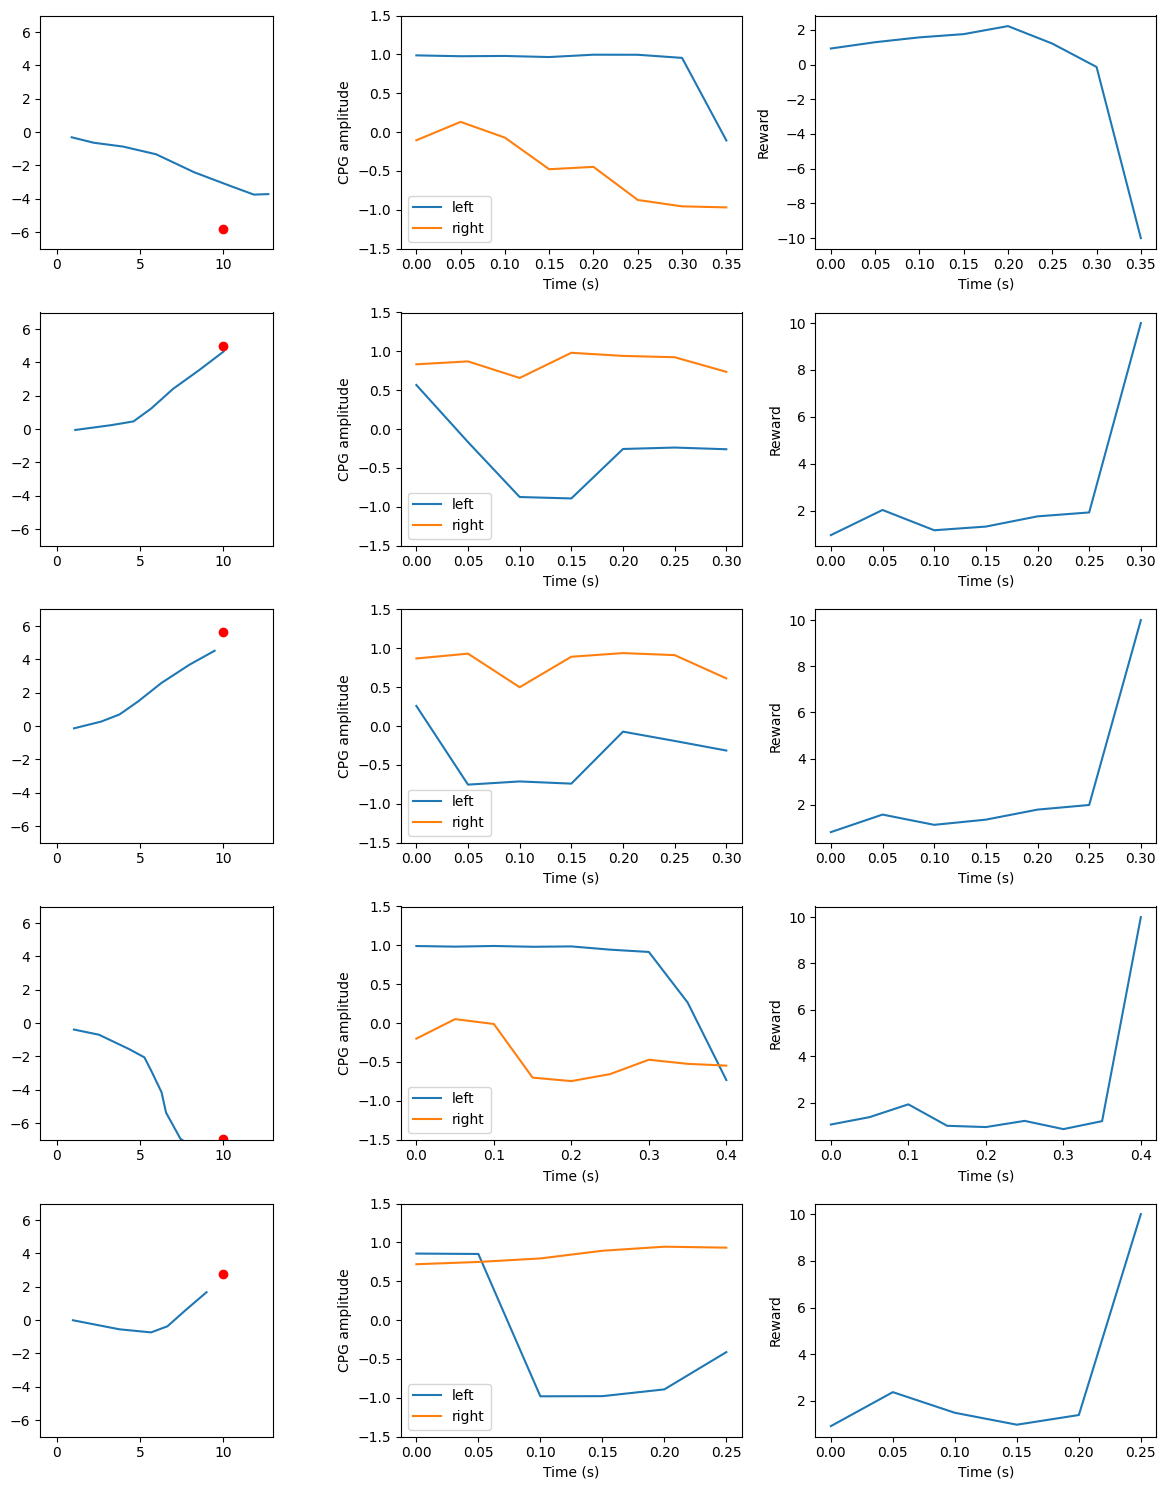

In [16]:
num_trials = 5
fig, axs = plt.subplots(num_trials, 3, figsize=(12, 3 * num_trials), tight_layout=True)

for i in range(num_trials):
    print(f"Running trial {i}")
    obs, info = task.reset()
    pos_hist = []
    action_hist = []
    reward_hist = []
    while True:
        action, _states = model.predict(obs, deterministic=True)
        obs, reward, terminated, truncated, info = task.step(action)
        pos = task.nmf_cpg.get_observation()["fly"][0, :2]
        action_hist.append(action)
        pos_hist.append(pos)
        reward_hist.append(reward)
        if terminated:
            print("Terminated")
            break
        if truncated:
            print("Truncated")
            break

    pos_hist = np.array(pos_hist)
    axs[i, 0].plot(pos_hist[:, 0], pos_hist[:, 1])
    axs[i, 0].plot([task.target_pos[0]], [task.target_pos[1]], "ro")
    axs[i, 0].set_xlim(-1, 13)
    axs[i, 0].set_ylim(-7, 7)
    axs[i, 0].set_aspect("equal")

    action_hist = np.array(action_hist)
    t = np.arange(action_hist.shape[0]) * task.decision_dt
    axs[i, 1].plot(t, action_hist[:, 0], label="left")
    axs[i, 1].plot(t, action_hist[:, 1], label="right")
    axs[i, 1].set_ylim(-1.5, 1.5)
    axs[i, 1].legend()
    axs[i, 1].set_xlabel("Time (s)")
    axs[i, 1].set_ylabel("CPG amplitude")

    reward_hist = np.array(reward_hist)
    axs[i, 2].plot(t, reward_hist)
    axs[i, 2].set_xlabel("Time (s)")
    axs[i, 2].set_ylabel("Reward")